In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from scipy import ndimage
from matplotlib import pyplot
import scipy
from PIL import Image
from skimage import measure
import math
from tqdm import tqdm_notebook as tqdm
from skimage import morphology,draw
import os
import pandas as pd
%pylab inline
from imageio import imread
import pickle
from scipy.stats import pearsonr,spearmanr

/home/xupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/xupeng/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
cd ..

/home/xupeng/projects/membrane/nm


In [4]:
import seaborn as sns
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[2])
sns.set_style(styles[3])

In [5]:
overlaps = pd.read_excel('data/nmjstatistics/overlap.xlsx').iloc[2:,1:]

In [6]:
def get_kvalue(diameters,overlaps): 
    kvalues = np.ndarray([35,13])
    for i in range(35):
        for j in range(13):
            #print (i,j)
            if (diameters.iloc[i,j]>0) & (overlaps.iloc[int(i/5),j]>0):
                kvalues[i,j] = (overlaps.iloc[int(i/5),j]*32*32*10**(-6))/(diameters.iloc[i,j]*8*0.001)
            else:
                kvalues[i,j] = 0
    diameters_mean = np.average(np.array(diameters).T.reshape(13,7,5),axis=2).T
    kvalues_ = np.ndarray([7,13])
    for i in range(7):
        for j in range(13):
            #print (i,j)
            if (diameters.iloc[i,j]>0) & (diameters_mean[i,j]>0):
                kvalues_[i,j] = (overlaps.iloc[int(i/5),j]*32*32*10**(-6))/(diameters_mean[i,j]*8*0.001)
            else:
                kvalues_[i,j] = 0
    return kvalues,kvalues_,diameters_mean
#plt.plot(kvalues_.ravel())
#hist(kvalues_.ravel(),bins=50)

In [7]:
def prepare_needarr(diameters,overlaps,diameters_mean):
    needarr = np.concatenate((8*0.001*diameters_mean.ravel().reshape(-1,1),32*32*(10**(-6))*np.array(overlaps).ravel().reshape(-1,1),
                         np.meshgrid(np.arange(1,8),np.arange(1,14))[0].T.reshape(-1,1).astype('int'),
                         np.meshgrid(np.arange(1,8),np.arange(1,14))[1].T.reshape(-1,1).astype('int'),
                         np.repeat(5,91).reshape(-1,1))
               ,axis=1)
    dataframe =pd.DataFrame(needarr,columns=['Axonal diameter ( $\mu m$ )','Contact area ( $\mu m ^2$ )','Axon','Muscle','size'])
    nonzeroind = np.where(np.sum(needarr[:,:2] ,axis=1) !=0)[0]
    return dataframe,nonzeroind

In [8]:
def draw_all(dataframe,nonzeroind):
    sns.set(style="darkgrid")
    #fig,ax=plt.subplots(1,figsize=(10,10))
    g = sns.jointplot("Axonal diameter ( $\mu m$ )", "Contact area ( $\mu m ^2$ )", data=dataframe.iloc[nonzeroind], kind="reg",
                      xlim=(0, 0.35), ylim=(0, 35))
    print (pearsonr(np.array(dataframe.iloc[nonzeroind,0]),np.array(dataframe.iloc[nonzeroind,1])))
    print (scipy.stats.spearmanr(np.array(dataframe.iloc[nonzeroind,0]),np.array(dataframe.iloc[nonzeroind,1])))

In [9]:
diameter1 = pd.read_excel('data/nmjstatistics/diameters_v1.xlsx')
diameter2 = pd.read_excel('data/nmjstatistics/diameters_v2.xlsx')

(0.728385375090318, 8.92449202810003e-13)
SpearmanrResult(correlation=0.7580264193858806, pvalue=3.0122939078780954e-14)


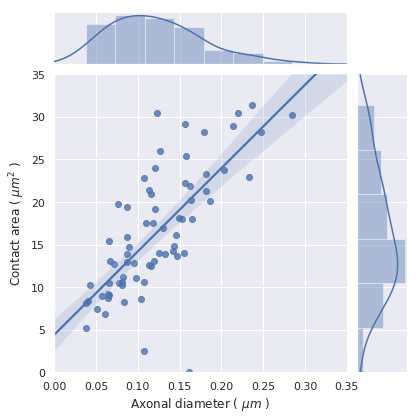

In [10]:
dataframe1, nonzeroind1 = prepare_needarr(diameter1,overlaps,get_kvalue(diameter1,overlaps)[2])
draw_all(dataframe1, nonzeroind1)

(0.7318601834830429, 9.074805969072434e-13)
SpearmanrResult(correlation=0.762666812845232, pvalue=2.6408320231601365e-14)


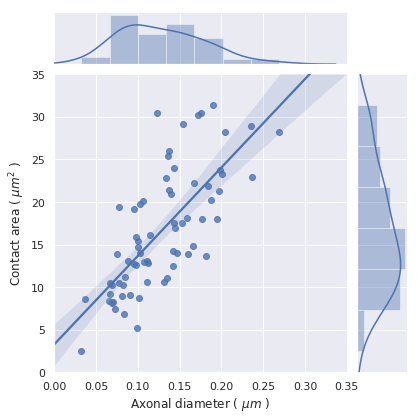

In [11]:
dataframe2, nonzeroind2 = prepare_needarr(diameter2,overlaps,get_kvalue(diameter2,overlaps)[2])
draw_all(dataframe2, nonzeroind2)

In [12]:
def plot_axon(ind,dataframe,nonzeroind):
    #fig,ax=plt.subplots(1,figsize=(10,10))
    newind = nonzeroind[np.where((nonzeroind<(ind+1)*13)&(ind*13<=nonzeroind))[0]]
    g = sns.jointplot("Axonal diameter ( $\mu m$ )", "Contact area ( $\mu m ^2$ )", data=dataframe.iloc[newind], kind="reg",
                  xlim=(0, 0.35), ylim=(0, 35))
    print ('Axon',str(ind),' PCC: ',str('%01f'%pearsonr(np.array(dataframe.iloc[newind,0]),np.array(dataframe.iloc[newind,1]))[0]),
          'Spearmanr: ',str('%01f'%scipy.stats.spearmanr(np.array(dataframe.iloc[newind,0]),np.array(dataframe.iloc[newind,1]))[0])
          )
    #ax = sns.scatterplot("Axonal iameter ( $\mu m$ )", "Synaptic area ( $\mu m ^2$ )",
          #      data=dataframe.iloc[newind],hue='Muscle',legend="full",style='Axon')
def plot_muscle(ind,dataframe,nonzeroind):
    newind = nonzeroind[np.where(np.remainder(nonzeroind,13) ==ind)]
    g = sns.jointplot("Axonal diameter ( $\mu m$ )", "Contact area ( $\mu m ^2$ )", data=dataframe.iloc[newind], kind="reg",
                  xlim=(0, 0.35), ylim=(0, 35))
    print ('Muscle',str(ind),' PCC: ',str('%01f'%pearsonr(np.array(dataframe.iloc[newind,0]),np.array(dataframe.iloc[newind,1]))[0]),
          'Spearmanr: ',str('%01f'%scipy.stats.spearmanr(np.array(dataframe.iloc[newind,0]),np.array(dataframe.iloc[newind,1]))[0])
          )
def get_k(ind,dataframe):
    newind = nonzeroind[np.where(np.remainder(nonzeroind,13) ==ind)]
    return np.array(dataframe.iloc[newind,1])/np.array(dataframe.iloc[newind,0])    

Axon 0  PCC:  0.725397 Spearmanr:  0.714286
Axon 1  PCC:  0.645657 Spearmanr:  0.354545
Axon 2  PCC:  0.818450 Spearmanr:  0.748252
Axon 3  PCC:  0.937598 Spearmanr:  0.892857
Axon 4  PCC:  0.734401 Spearmanr:  0.500000
Axon 5  PCC:  0.517372 Spearmanr:  0.398601
Axon 6  PCC:  0.936196 Spearmanr:  0.939560


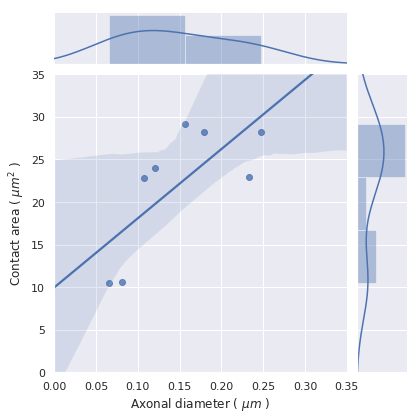

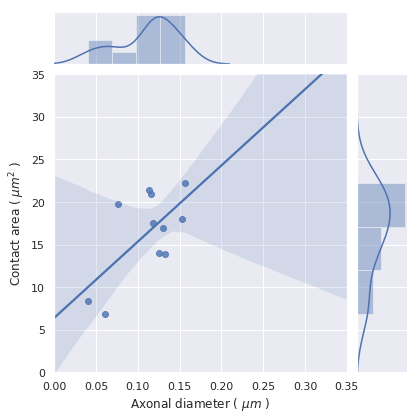

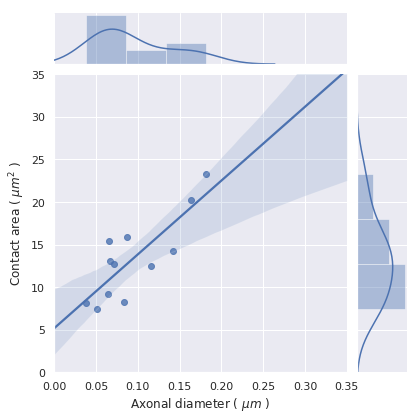

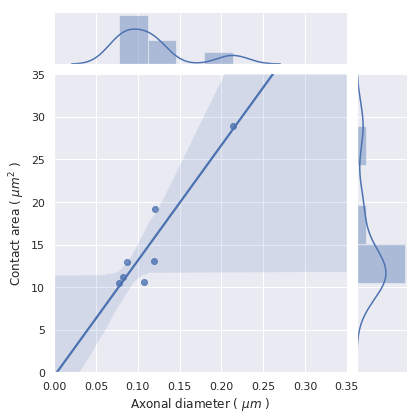

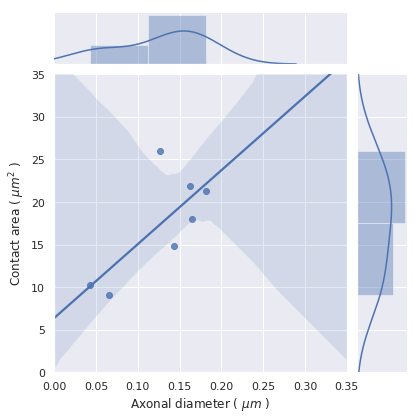

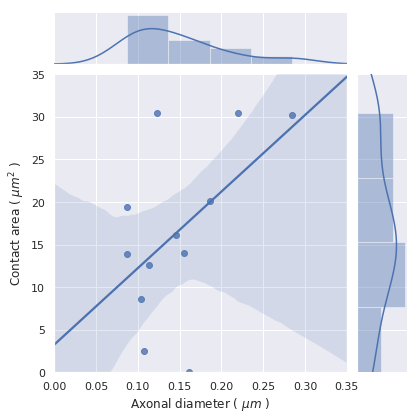

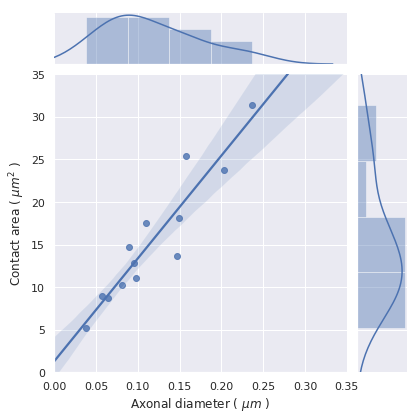

In [13]:
for i in range(7):
    plot_axon(i,dataframe1,nonzeroind1)

Axon 0  PCC:  0.709719 Spearmanr:  0.714286
Axon 1  PCC:  0.640340 Spearmanr:  0.309091
Axon 2  PCC:  0.884102 Spearmanr:  0.818182
Axon 3  PCC:  0.834828 Spearmanr:  0.535714
Axon 4  PCC:  0.662686 Spearmanr:  0.500000
Axon 5  PCC:  0.888672 Spearmanr:  0.900000
Axon 6  PCC:  0.742107 Spearmanr:  0.785714


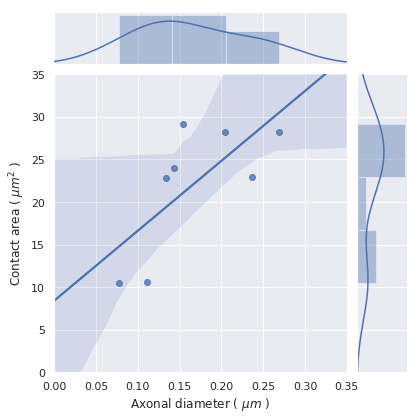

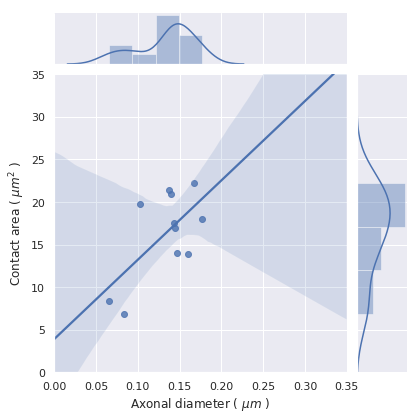

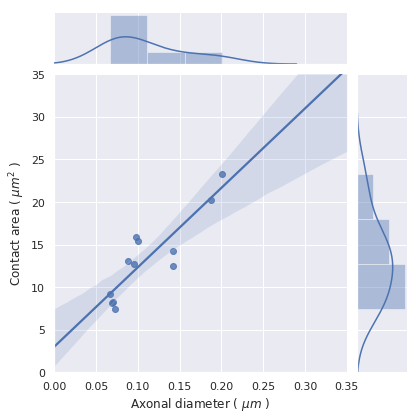

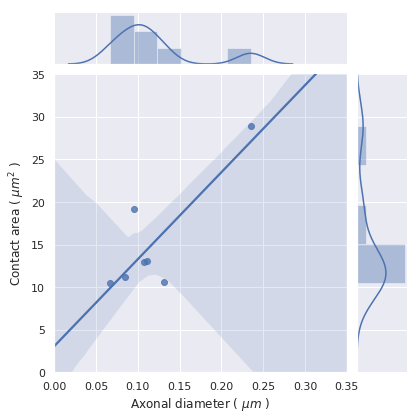

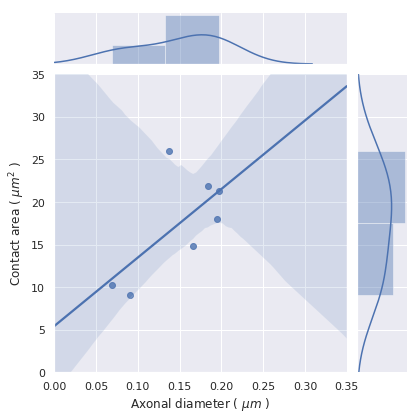

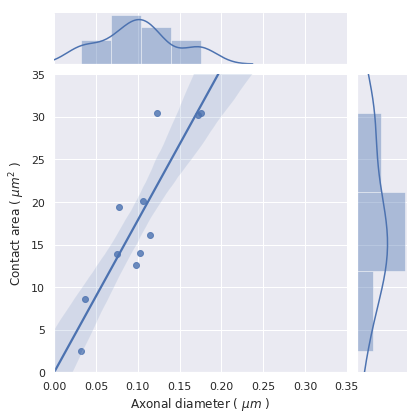

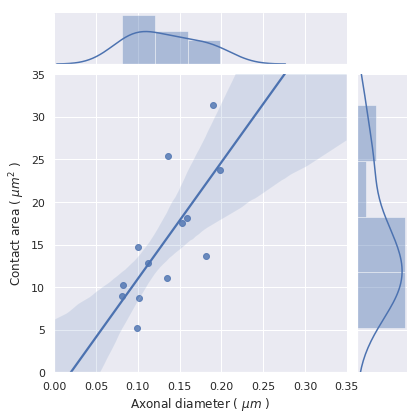

In [14]:
for i in range(7):
    plot_axon(i,dataframe2,nonzeroind2)

sums = np.sum(np.array(overlaps),axis=1).sum()
#occusort = np.flip(np.sort(np.sum(np.array(overlaps),axis=1)),axis=0)/sums*100
pddata = pd.DataFrame(np.sum(np.array(overlaps),axis=1).reshape(1,-1)/sums*100,columns = np.arange(0,7))
fig,ax=plt.subplots(1,figsize=(10,8))
ax = sns.barplot(data=pddata,saturation=10,linewidth=1.5,edgecolor=".2",palette=colorsgallery[:7])
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(np.arange(1,8))
ax.set_xlabel('Axon number', fontsize=16)
ax.set_title('Size distribution of Contact area', fontsize=16)
ax.set_ylabel('Occupancy (%)', fontsize=16)

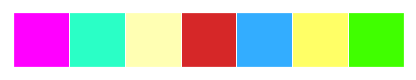

In [15]:
colorforhist = np.array([(214/255., 39/255., 40/255.),(1, 1, 179/255.),
                        (51/255., 173/255., 1),(64/255., 1, 0),
                        (1, 1, 102/255.),(26/155., 1, 198/255.),
                        (1,0,1)])
sns.palplot(colorforhist[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)])

In [16]:
_,_,diameters_mean2 = get_kvalue(diameter2,overlaps)

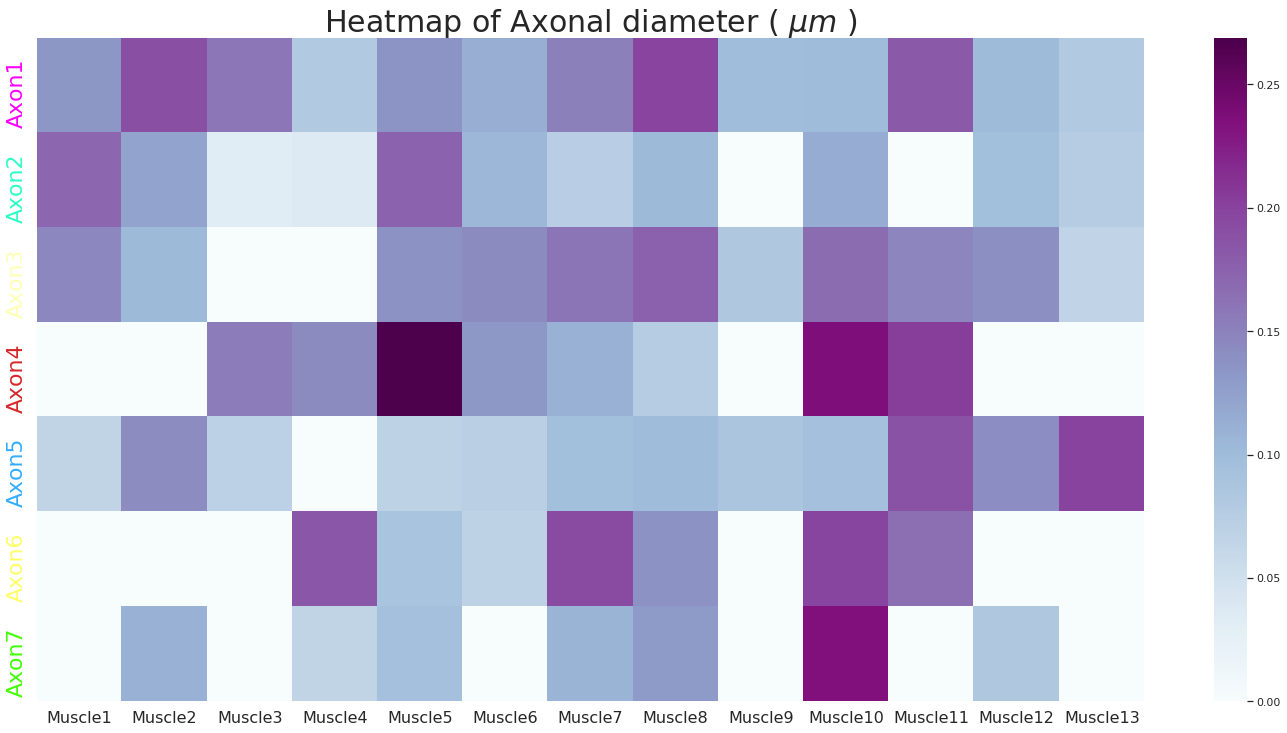

In [17]:
fig,ax=plt.subplots(1,figsize=(20,10))
sns.heatmap(8*0.001*diameters_mean2[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)],cmap="BuPu")
ax.set_xticks(np.arange(0.5,13.5))
ax.set_xticklabels(np.array(['Muscle'+str(i+1) for i in range(13)]),fontsize=16)
ax.set_yticks(np.arange(0.3,7.3))
ax.set_yticklabels(np.array(['Axon'+str(i+1) for i in range(7)]),fontsize=22)
fig.tight_layout()
ax.set_title('Heatmap of Axonal diameter ( $\mu m$ )', fontsize=30)
colors = colorforhist[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)]
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)

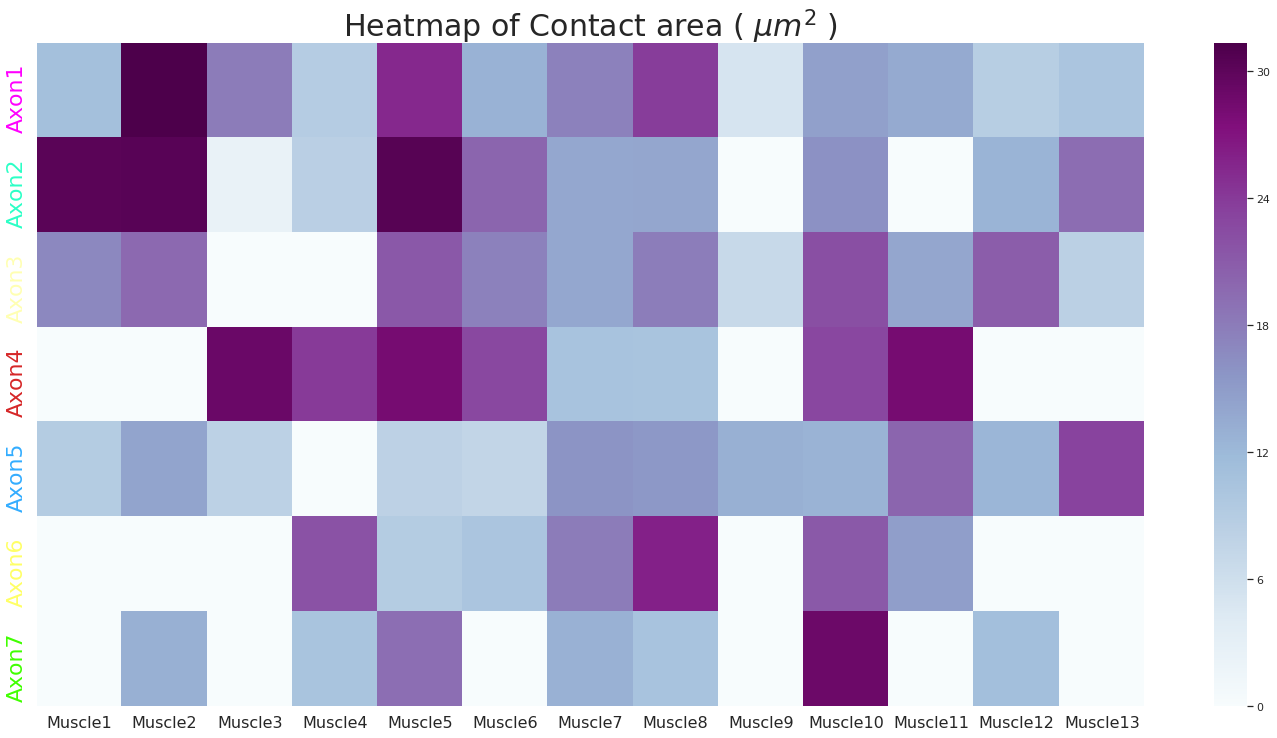

In [18]:
fig,ax=plt.subplots(1,figsize=(20,10))
sns.heatmap(32*32*(10**(-6))*np.array(overlaps)[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)],cmap="BuPu")
ax.set_xticks(np.arange(0.5,13.5))
ax.set_xticklabels(np.array(['Muscle'+str(i+1) for i in range(13)]),fontsize=16)
ax.set_yticks(np.arange(0.3,7.3))
ax.set_yticklabels(np.array(['Axon'+str(i+1) for i in range(7)]),fontsize=22)
fig.tight_layout()
ax.set_title('Heatmap of Contact area ( $\mu m ^2$ )' ,fontsize=30)
colors = colorforhist[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)]
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)

Text(0,0.5,'Occupancy (%)')

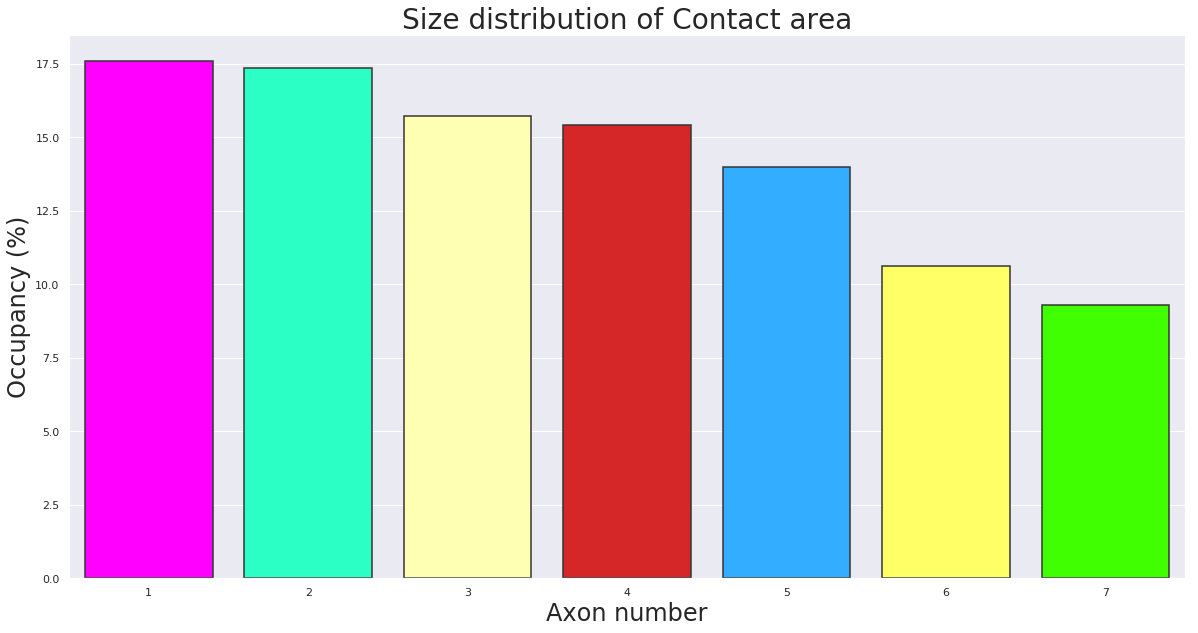

In [19]:
sums = np.sum(np.array(overlaps),axis=1).sum()
occusort = np.flip(np.sort(np.sum(np.array(overlaps),axis=1)),axis=0)/sums*100
pddata = pd.DataFrame(occusort.reshape(1,-1),columns = np.arange(0,7))
fig,ax=plt.subplots(1,figsize=(20,10))
ax = sns.barplot(data=pddata,saturation=10,linewidth=1.5,edgecolor=".2",palette=colorforhist[np.flip(np.argsort(np.sum(np.array(overlaps),axis=1)),axis=0)])
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(np.arange(1,8))
ax.set_xlabel('Axon number', fontsize=24)
ax.set_title('Size distribution of Contact area', fontsize=28)
ax.set_ylabel('Occupancy (%)', fontsize=24)